In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random

In [3]:
# Define a Classif10 neural network
class Classif10(torch.nn.Module):
    def __init__(self, number_of_conv_kernels1,
                 number_of_conv_kernels2,
                 number_of_conv_kernels3,
                 hidden_layer_size,
                 dropout_proportion):
        super(Classif10, self).__init__()
        self.number_of_conv_kernels1 = number_of_conv_kernels1
        self.number_of_conv_kernels2 = number_of_conv_kernels2
        self.number_of_conv_kernels3 = number_of_conv_kernels3
        self.hidden_layer_size = hidden_layer_size

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=self.number_of_conv_kernels1,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.conv2 = torch.nn.Conv2d(in_channels=self.number_of_conv_kernels1, out_channels=self.number_of_conv_kernels2,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.conv3 = torch.nn.Conv2d(in_channels=self.number_of_conv_kernels2, out_channels=self.number_of_conv_kernels3,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.dropout2d = torch.nn.Dropout2d(p=dropout_proportion)
        self.maxpool2d = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.batchnorm2d = torch.nn.BatchNorm2d(num_features=self.number_of_conv_kernels2)
        self.linear1 = torch.nn.Linear(in_features=self.number_of_conv_kernels3 * 3 * 3, out_features=self.hidden_layer_size)
        self.linear2 = torch.nn.Linear(in_features=self.hidden_layer_size, out_features=10)
        self.dropout1d = torch.nn.Dropout1d(p=dropout_proportion)

    def forward(self, input_tsr):  # input_tsr.shape = (N, 1, 28, 28)
        act1 = torch.nn.functional.relu(self.conv1(input_tsr))  # (N, C1, 28, 28)
        act2 = self.maxpool2d(act1)  # (N, C1, 14, 14)
        act3 = self.dropout2d(act2)  # (N, C1, 14, 14)
        act4 = torch.nn.functional.relu(self.conv2(act3))  # (N, C2, 14, 14)
        act5 = self.maxpool2d(act4)  # (N, C2, 7, 7)
        act6 = self.batchnorm2d(act5)  # (N, C2, 7, 7)
        act7 = torch.nn.functional.relu(self.conv3(act6))  # (N, C3, 7, 7)
        act8 = self.maxpool2d(act7)  # (N, C3, 3, 3)
        act9 = act8.view(-1, self.number_of_conv_kernels3 * 3 * 3)  # (N, C3 * 3 * 3)
        act10 = torch.nn.functional.relu(self.linear1(act9))  # (N, H)
        act11 = self.dropout1d(act10)  # (N, H)
        act12 = self.linear2(act11)  # (N, 10)
        return act12

In [4]:
# Create the neural network
neural_net = Classif10(16, 32, 64, 256, 0.1)
# Load the champion classification neural network
# neural_net.load_state_dict(torch.load("/usercode/classification_champion.pth"))
neural_net.load_state_dict(torch.load("./output_train_mnist_classif10/classification_champion.pth"))

# Set the neural network to inference (eval) mode
neural_net.eval()

Classif10(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchnorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout1d): Dropout1d(p=0.1, inplace=False)
)

In [5]:
# Load the MNIST test dataset: set train=False
transform = torchvision.transforms.ToTensor()
mnist_test_dataset = torchvision.datasets.MNIST("./", train=False, download=True, transform=transform)

In [12]:
# Select a random sample from the test dataset
random_indices = random.sample(range(0, len(mnist_test_dataset)), k=16)
# For each index, get the image and pass it through the neural network
predicted_classes = []
image_tsrs = []
true_classes = []
for i in random_indices:
    image_tsr, class_ndx = mnist_test_dataset[i]
    output_tsr = neural_net(image_tsr.unsqueeze(0).to('cpu'))
    predicted_class = torch.argmax(output_tsr, dim=1).item()
    #print(f"predicted_class = {predicted_class}")
    predicted_classes.append(predicted_class)
    image_tsrs.append(image_tsr)
    true_classes.append(class_ndx)


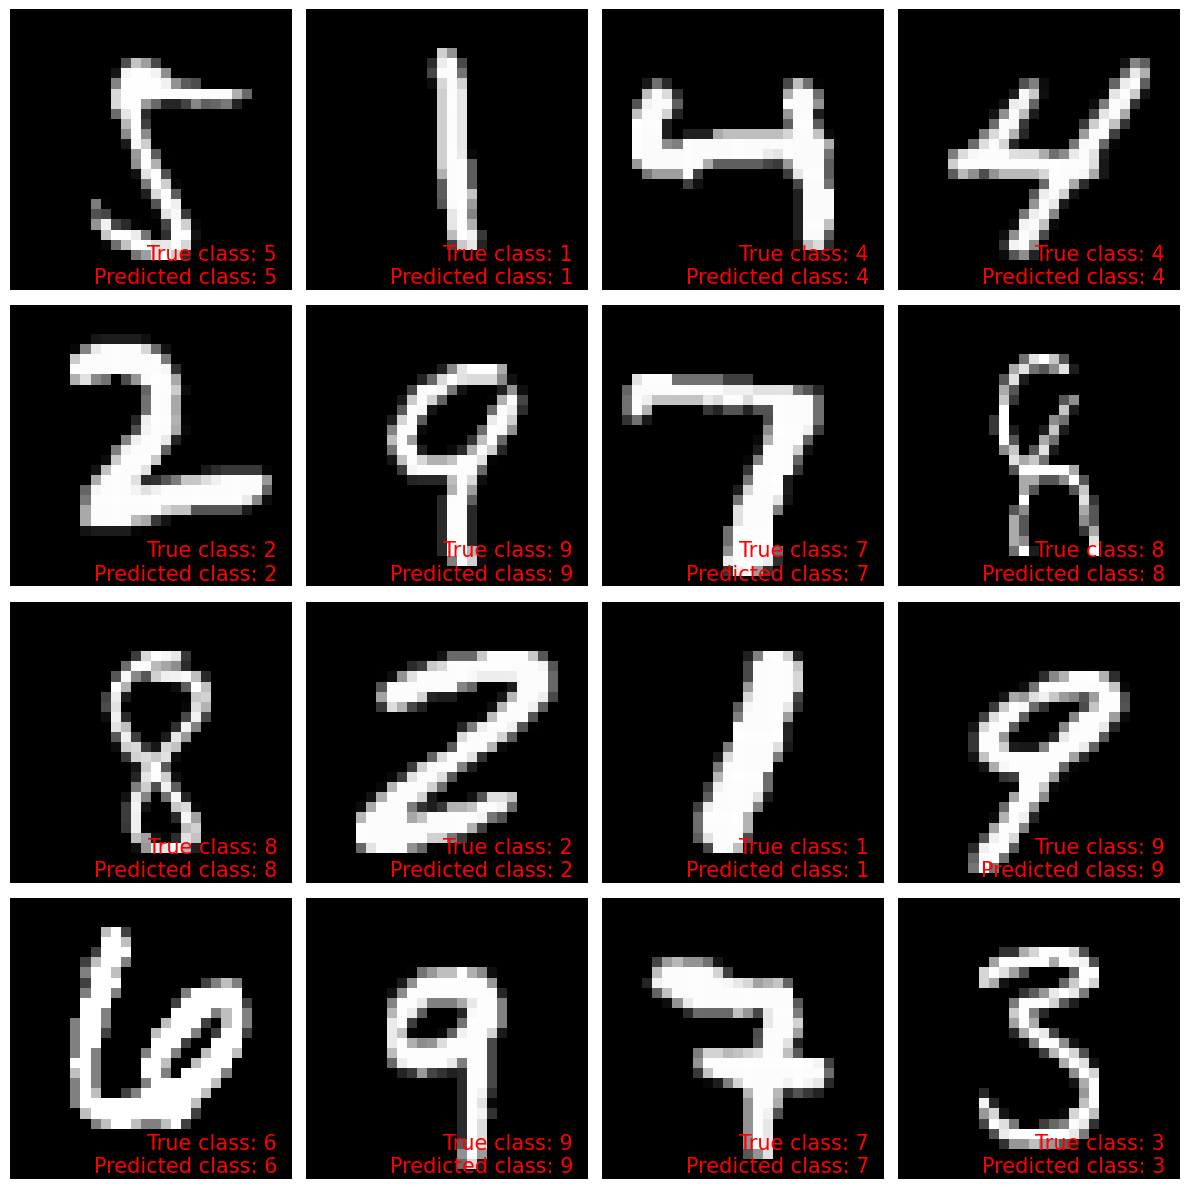

In [28]:
# Display the images, the true class and the predicted class
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    if i < len(image_tsrs):
        ax.imshow(image_tsrs[i].squeeze(0), cmap='gray')
        ax.text(0.95, 0.01, f'True class: {true_classes[i]}\nPredicted class: {predicted_classes[i]}',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='red', fontsize=15)

    ax.axis('off')

plt.tight_layout()
plt.show()
        